In [114]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import confusion_matrix
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
df = data_tracks.get_tracks() # note: different Xs can be different shapes
df = data_tracks.remove_invalid_tracks(df)
df = data_tracks.preprocess(df)
df = data_tracks.add_outcome(df)
n = df.shape[0]

# make logistic data
# feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement']
feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 'rise', 'fall']
X_mean = X.mean()
X_std = X.std()
norms = {
    feat_names[i]: {'mu': X_mean[i], 'std': X_std[i]} for i in range(len(feat_names))
}
X = df[feat_names]
X = (X - X_mean) / X_std
y = df['outcome'].values


# split testing data based on cell num
idxs_test = df.cell_num.isin([6])
X_test, Y_test = X[idxs_test], y[idxs_test]

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     fig, ax = plt.subplots()
    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    ax = plt.gca()
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
#            title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax

def visualize_individual_results(results):
    scores_cv = results['cv']
    scores_test = results['test']
    imps = results['imps']
    m = imps['model'][0]
    print(Fore.CYAN + f'{"metric":<25}\tvalidation') #\ttest')
    for s in results['metrics']:
        if not 'curve' in s:
            print(Fore.WHITE + f'{s:<25}\t{np.mean(scores_cv[s]):.3f} ~ {np.std(scores_cv[s]):.3f}')
    #         print(Fore.WHITE + f'{s:<25}\t{np.mean(scores_cv[s]):.3f} ~ {np.std(scores_cv[s]):.3f}\t{np.mean(scores_test[s]):.3f} ~ {np.std(scores_test[s]):.3f}')

    print(Fore.CYAN + '\nfeature importances')
    imp_mat = np.array(imps['imps'])
    imp_mu = imp_mat.mean(axis=0)
    imp_sd = imp_mat.std(axis=0)
    for i, feat_name in enumerate(results['feat_names']):
        print(Fore.WHITE + f'{feat_name:<25}\t{imp_mu[i]:.3f} ~ {imp_sd[i]:.3f}')

    # print(m.coef_)
    plt.figure(figsize=(10, 3), dpi=140)
    R, C = 1, 3
    plt.subplot(R, C, 1)
    preds = m.predict(X_test)
    preds_proba = m.predict_proba(X_test)[:, 1]    
    plot_confusion_matrix(Y_test, preds, classes=np.array(['Failure', 'Success']))
    


    plt.subplot(R, C, 2)
    prec, rec, thresh = scores_test['precision_recall_curve'][0]
    plt.plot(rec, prec)
    plt.xlim((-0.1, 1.1))
    plt.ylim((-0.1, 1.1))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    
    
    plt.subplot(R, C, 3)

    plt.hist(preds_proba[Y_test==0], alpha=0.5, label='Failure')
    plt.hist(preds_proba[Y_test==1], alpha=0.5, label='Success')
    plt.xlabel('Predicted probability')
    plt.ylabel('Count')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return preds, preds_proba

out_dir = 'results/classify'
results = pkl.load(open(oj(out_dir, 'rf.pkl'), 'rb'))
preds, preds_proba = visualize_individual_results(results)

In [186]:
def highlight_max(data, color='#0e5c99'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)



def visualize_metrics(out_dir):
    r = []
    for fname in os.listdir(out_dir):
        d = pkl.load(open(oj(out_dir, fname), 'rb'))
        metrics = {k: d['cv'][k] for k in d['cv'].keys() if not 'curve' in k}
        out = {k: np.mean(metrics[k]) for k in metrics}
        out.update({k + '_std': np.std(metrics[k]) for k in metrics})
        out['model_type'] = fname.replace('.pkl', '') #d['model_type']
#         out['num_features'] = len(d['feat_names'])
        r.append(pd.Series(out))
    r = pd.concat(r, axis=1).T.infer_objects()
    r = r.reindex(sorted(r.columns), axis=1) # sort the column names
    r = r.round(3)
    r = r.set_index('model_type')
    return r.sort_values('model_type')


def visualize_feature_importances(out_dir):
    r = []
    for fname in os.listdir(out_dir):
        d = pkl.load(open(oj(out_dir, fname), 'rb'))
        imp_mat = np.array(d['imps']['imps'])
        imp_mu = imp_mat.mean(axis=0)
        imp_sd = imp_mat.std(axis=0)
        out = {feat_names[i]: imp_mu[i] for i in range(len(feat_names))}
        out.update({feat_names[i]+'_std': imp_sd[i] for i in range(len(feat_names))})
        out['model_type'] = fname.replace('.pkl', '') #d['model_type']
#         out['num_features'] = len(d['feat_names'])        
        r.append(pd.Series(out))
    r = pd.concat(r, axis=1).T.infer_objects()
    r = r.reindex(sorted(r.columns), axis=1) # sort the column names
    r = r.round(3)
    r = r.set_index('model_type')
    return r

out_dir = 'results/classify_new'
r = visualize_metrics(out_dir)
r = r[[k for k in r if not 'std' in k]]
# r
r = r.sort_values('balanced_accuracy', ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r.style.background_gradient(cmap='viridis', axis=0) # columns differently colored
# r.style.apply(highlight_max, subset=[k for k in r if not 'std' in k])

,accuracy,balanced_accuracy,f1,precision,recall,roc_auc
model_type,,,,,,
rf_ros_7,0.891,0.812,0.721,0.794,0.677,0.95
rf_ros_6,0.888,0.808,0.714,0.788,0.67,0.952
rf_ros_9,0.888,0.807,0.713,0.788,0.668,0.951
rf_smote_7,0.883,0.798,0.721,0.855,0.634,0.95
rf_smote_6,0.883,0.798,0.721,0.858,0.634,0.95
rf_ros_4,0.881,0.797,0.699,0.777,0.649,0.943
rf_smote_9,0.883,0.797,0.719,0.851,0.634,0.949
logistic_smote_9,0.88,0.795,0.724,0.895,0.619,0.954
logistic_ros_9,0.88,0.795,0.727,0.904,0.618,0.955


In [131]:
r2 = visualize_feature_importances(out_dir)
# r2.style.apply(highlight_max, subset=[k for k in r if not 'std' in k])
# r2 = r2[[k for k in r2 if not 'std' in k]]
r2

,X_max,X_max_std,lifetime,lifetime_std,mean_square_displacement,mean_square_displacement_std,total_displacement,total_displacement_std
model_type,,,,,,,,
logistic,0.585,0.041,2.619,0.132,-1.617,0.177,0.225,0.039
svm,0.000,0.012,0.166,0.025,0.011,0.006,0.000,0.003
dt,0.107,0.006,0.721,0.003,0.089,0.006,0.082,0.004
rf,0.211,0.014,0.582,0.018,0.116,0.005,0.091,0.005
mlp2,0.004,0.018,0.159,0.028,0.002,0.006,-0.001,0.002


# analyze dependence on lifetime

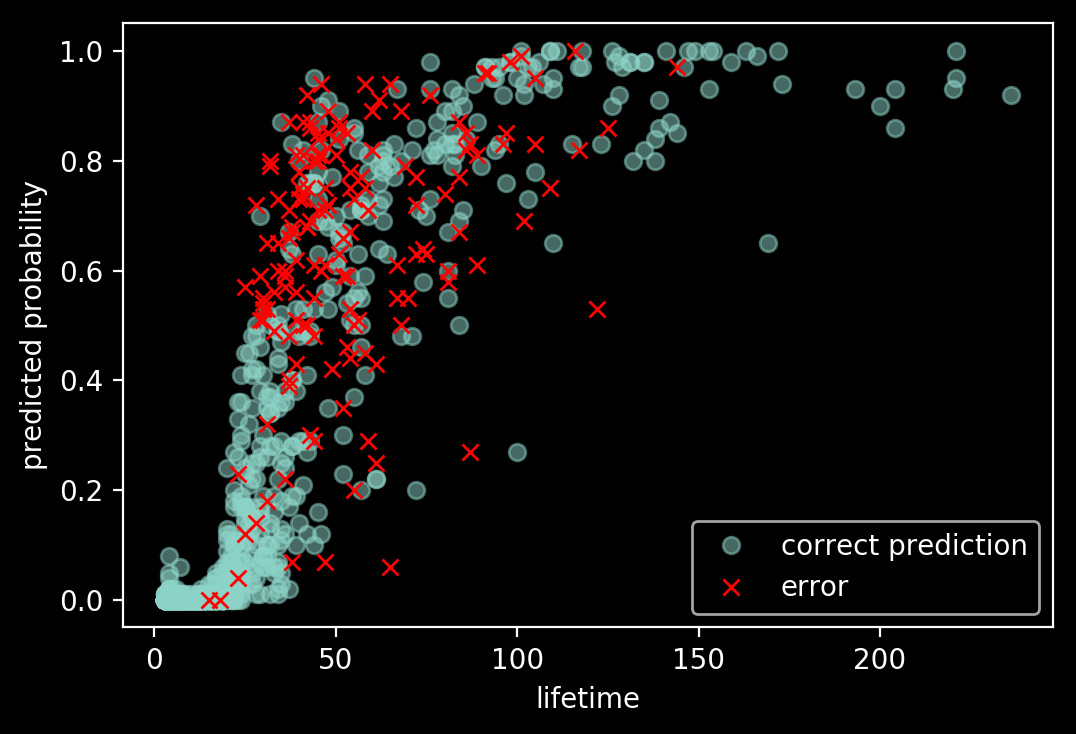

In [153]:
plt.figure(dpi=200)
correct_idxs = preds == Y_test
lifetime = X_test['lifetime'] * norms['lifetime']['std'] + norms['lifetime']['mu']
plt.plot(lifetime[correct_idxs], preds_proba[correct_idxs], 'o', alpha=0.5, label='correct prediction')
plt.plot(lifetime[~correct_idxs], preds_proba[~correct_idxs], 'x', color='red', label='error')
plt.xlabel('lifetime')
plt.ylabel('predicted probability')
plt.legend()
plt.show()